# **RSNA-MICCAI Brain Tumor Radiogenomic Classification**
**Predict the status of a genetic biomarker important for brain cancer treatment**

# **Imports and variable declarations**

This section contains the libraries used in the notebook as well as the variables relating to the parameters of the generated network.

In [1]:
import os # os functionalities
import re # regular expressions
import warnings # avoid tf warnings
import numpy as np # linear algebra
import pandas as pd # data processing
from skimage import io # image manipulation
from matplotlib import pyplot as plt # image visualization
warnings.filterwarnings('ignore') # ignore tensorflow warnings

import seaborn as sns

# Tensorflow & Keras & SkLearn
import keras
import tensorflow as tf 
from tensorflow.keras.metrics import AUC # area under ROC curve
from keras.applications.vgg16 import VGG16 # pretrained model
from sklearn.model_selection import train_test_split # divide dataset
from sklearn.metrics import confusion_matrix # metrics for assesing the model

In [2]:
# Variable declaration
'''
Images for an specific patient are selected following one of these criteria
    - central: Since all the images of the same patient are ordered by their id, the one in the middle is seletected
    - first: Select the first one to appear
    - all: Select all the available images for a given patient
'''
patient_mode = "all" # all - central - first 
image_mode = "T2w" # FLAIR - T1w - T1wCE - T2w

# Paths to images
input_dir = "../input/rsna-miccai-png/train" 
target_dir = "../input/rsna-miccai-png/test"

# Model variables
epochs = 7
batch_size = 64
learning_rate = 0.01
optimizer = "RMSprop"
loss_function = "binary_crossentropy"

# **Data loading**

In [3]:
# Get path to the training images
input_img_paths_patients = sorted([
    os.path.join(input_dir, fname + "/" + image_mode) 
    for fname in os.listdir(input_dir)
    if os.path.exists(os.path.join(input_dir, fname + "/" + image_mode))])

# Get images id's by a specific criteria
input_img_paths = []
for patient in input_img_paths_patients:
    images_id = x = [int(re.findall(r'\d+', x)[0]) for x in os.listdir(patient)] # Get all image ids
    '''
    Images for an specific patient are selected following one of these criteria
    - central: Since all the images of the same patient are ordered by their id, the one in the middle is seletected
    - first: Select the first one to appear
    - all: Select all the available images for a given patient
    '''
    if patient_mode == "central":  # Get middle image
        index_central_image = min(images_id) + round((max(images_id) - min(images_id))/2)
        path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
        if os.path.exists(path): input_img_paths.append(path)
    if patient_mode == "first": # Get first image
        index_central_image = min(images_id) 
        path = os.path.join(patient, "Image-" + str(index_central_image) + ".png")
        if os.path.exists(path): input_img_paths.append(path)
    if patient_mode == 'all': # Add all of the available images
        for image in images_id:
            path = os.path.join(patient, "Image-" + str(image) + ".png")
            if os.path.exists(path): input_img_paths.append(path)
        
# Read csv labels
df = pd.read_csv('../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv')

# Obtain pure labels
labels = []
for img_path in input_img_paths:
    labels.append(df.loc[df['BraTS21ID'] == int(re.findall(r'\d+', img_path)[0])]['MGMT_value'].iloc[0])

In [4]:
# Split data into train, validation and test
X_train, X_test, y_train, y_test = train_test_split(input_img_paths, labels, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.111, random_state=42) # 0.111*0.9 = 0.1

# Check amounts of data in each split
print(f"Training samples: {str(len(X_train))}\nValidation samples: {str(len(X_val))}\nTest samples: {str(len(X_test))}")

# Create dataframes for keras flow_from_dataframe
data = {'id': X_train, 'label': [str(x) for x in y_train]}
train_df = pd.DataFrame(data)

data = {'id': X_val, 'label': [str(x) for x in y_val]}
val_df = pd.DataFrame(data)

data = {'id': X_test, 'label': [str(x) for x in y_test]}
test_df = pd.DataFrame(data)

Training samples: 56583
Validation samples: 7066
Test samples: 7073


In [5]:
def load_dataset(train_df, val_df, test_df, data_augmentation=False):
    """
    This function loads the dataset from dataset folder
    :parameter train_df: Dataframe with paths to training images and labels
    :parameter val_df: Dataframe with paths to validation images and labels
    :parameter test_df: Dataframe with paths to test images and labels
    :parameter data_augmentation: Boolean indicating whether to include or not data augmentation
    :return train_generator: Training generator
    :return val_generator: Validation generator
    :return test_generator: Testing generator
    """

    # Create a data generator
    if data_augmentation:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0,
                                                                        rotation_range=20,
                                                                        width_shift_range=0.1,
                                                                        height_shift_range=0.1,
                                                                        zoom_range=0.2,
                                                                        horizontal_flip=True)
    else:
        datagen_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)
        
    datagen_val_test = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.0)

    # Load and iterate training dataset
    train_generator=datagen_train.flow_from_dataframe(dataframe=train_df, x_col="id", y_col="label", 
                                                      class_mode="binary", batch_size=batch_size, target_size=(224, 224))
    # Load and iterate validation dataset
    val_generator=datagen_val_test.flow_from_dataframe(dataframe=val_df, x_col="id", y_col="label", 
                                                       class_mode="binary", batch_size=batch_size, target_size=(224, 224))
    # Load and iterate test dataset
    test_generator=datagen_val_test.flow_from_dataframe(dataframe=test_df, x_col="id", y_col="label", 
                                                        class_mode="binary", batch_size=batch_size, target_size=(224, 224))

    return train_generator, val_generator, test_generator

In [6]:
# Load dataset
train_generator, val_generator, test_generator = load_dataset(train_df, val_df, test_df)

Found 56583 validated image filenames belonging to 2 classes.
Found 7066 validated image filenames belonging to 2 classes.
Found 7073 validated image filenames belonging to 2 classes.


## **Data visualization**

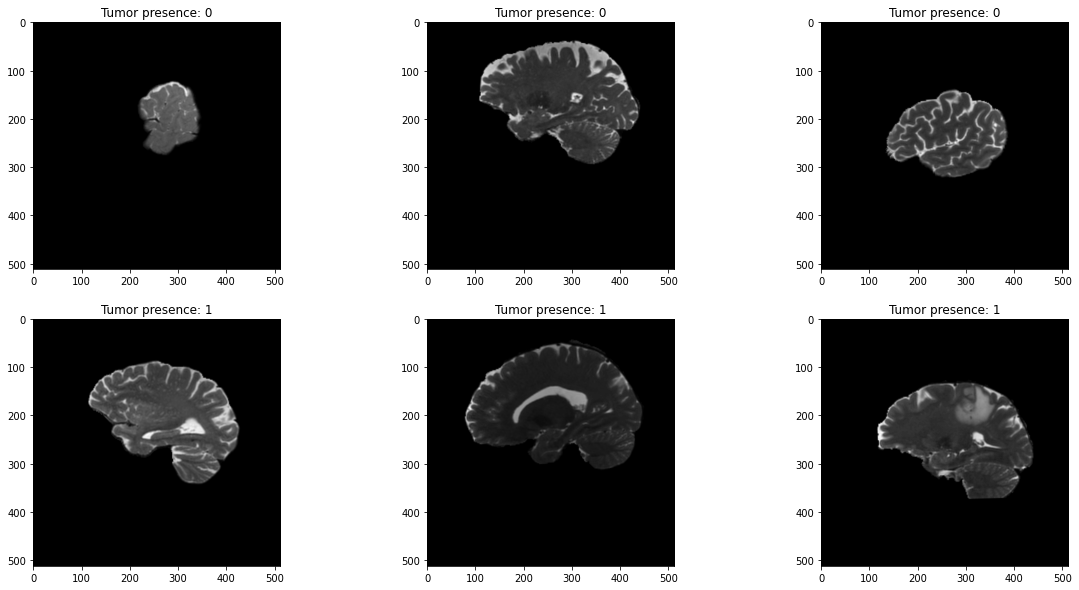

In [7]:
samples = 3 # Number of samples to select of each label

# samples are obtained for no tumor and tumor
selected = pd.concat([train_df[train_df.label.eq('0')].sample(samples), train_df[train_df.label.eq('1')].sample(samples)])

# Create figure
fig = plt.figure(figsize=(20, 10))

# Setting values to rows and column variables
rows = 2
columns = samples

# Plot images
for element in range(0, len(selected)):
    fig.add_subplot(rows, columns, element + 1)
    plt.imshow(io.imread(list(selected['id'])[element]), cmap='gray')
    plt.title(f"Tumor presence: {list(selected['label'])[element]}")

# **Model definition**

In [8]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')

# Make sure that the base_model is running in inference mode here, by passing `training=False`
base_model.trainable = False

# Define model structure
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# Dense classifier for binary classification
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dense(32, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary()

2022-12-09 22:05:22.094740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 22:05:22.259155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 22:05:22.259948: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-09 22:05:22.261870: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
______________________________________________________________

In [9]:
# Choose optimizer - SGD - RMSprop - Adam
if optimizer == "SGD": 
    fit_optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, decay=learning_rate/epochs)
elif optimizer == "RMSprop":
    fit_optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate, decay=learning_rate/epochs)
else: 
    fit_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-7, amsgrad=True)

# **Model training**

In [10]:
# Configure the model for training.
model.compile(optimizer=fit_optimizer, loss=loss_function, metrics=['accuracy', AUC()])

# Safe best model
callbacks = [keras.callbacks.ModelCheckpoint("brain_tumor.h5", save_best_only=True), tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]

# Train the model, doing validation at the end of each epoch.
model_history = model.fit(train_generator, epochs=epochs, validation_data=val_generator, callbacks=callbacks)

# Serialize and save model to json
'''model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)'''
    
# Serialize and save weights to HDF5
'''model.save_weights("model.h5")
print("Saved model to disk")'''

2022-12-09 22:05:26.392362: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/7


2022-12-09 22:05:28.859937: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


885/885 [==============================] - 487s 537ms/step - loss: 0.6709 - accuracy: 0.6001 - auc: 0.5670 - val_loss: 0.6633 - val_accuracy: 0.6001 - val_auc: 0.6122
Epoch 2/7
885/885 [==============================] - 252s 284ms/step - loss: 0.6576 - accuracy: 0.6138 - auc: 0.6069 - val_loss: 0.6540 - val_accuracy: 0.6176 - val_auc: 0.6254
Epoch 3/7
885/885 [==============================] - 249s 281ms/step - loss: 0.6513 - accuracy: 0.6226 - auc: 0.6240 - val_loss: 0.6559 - val_accuracy: 0.6169 - val_auc: 0.6334
Epoch 4/7
885/885 [==============================] - 247s 279ms/step - loss: 0.6477 - accuracy: 0.6260 - auc: 0.6334 - val_loss: 0.6535 - val_accuracy: 0.6090 - val_auc: 0.6385
Epoch 5/7
885/885 [==============================] - 251s 283ms/step - loss: 0.6447 - accuracy: 0.6292 - auc: 0.6398 - val_loss: 0.6504 - val_accuracy: 0.6158 - val_auc: 0.6448
Epoch 6/7
885/885 [==============================] - 249s 281ms/step - loss: 0.6411 - accuracy: 0.6318 - auc: 0.6476 - val_lo

'model.save_weights("model.h5")\nprint("Saved model to disk")'

In [11]:
# Accuracy plot to show the evolution of the training process
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title(f'Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f'MAMe_accuracy.pdf')
#plt.show()
plt.close()

# Loss plot to show the evolution of the training process
plt.figure(figsize=(7, 5), dpi=100)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title(f'Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(f'MAMe_loss.pdf')
#plt.show()
plt.close()

# **Model evaluation**

In [12]:
# Evaluate the model
test_generator.reset()
score = model.evaluate(test_generator, verbose=0)
print(f"Loss: {str(score[0])} \nAccuracy on test: {str(score[1])}\nAUC: {str(score[2])}")

Loss: 0.6394185423851013 
Accuracy on test: 0.6270323991775513
AUC: 0.6532865762710571


In [13]:
# Assign most probable label to predictions
test_generator.reset()
pred = model.predict(test_generator, verbose=0)
predicted_class_indices = np.round(pred)

# Get class labels
target_names = (test_generator.class_indices).keys()

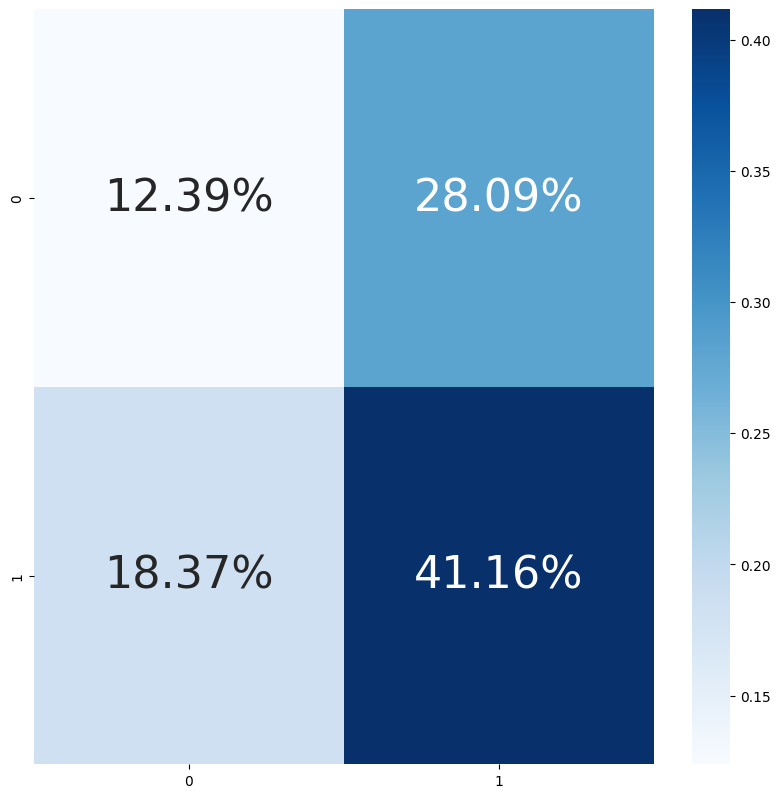

In [14]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
cf_matrix = confusion_matrix(np.array(test_generator.classes), predicted_class_indices)
heatmap = sns.heatmap(cf_matrix/np.sum(cf_matrix), fmt='.2%', annot=True, cmap='Blues', cbar=True, square=False, 
                      annot_kws={"fontsize":32}, xticklabels=target_names, yticklabels=target_names)
fig = heatmap.get_figure()
plt.savefig(f'Confusion_matrix.pdf')

EARLY STTOPING

In [15]:
'''pred = model.predict(test_generator, verbose=0)

from sklearn.metrics import roc_auc_score
predicted_class_indices = np.round(pred)
auc = roc_auc_score(test_generator.classes, predicted_class_indices)
print(auc)'''

'pred = model.predict(test_generator, verbose=0)\n\nfrom sklearn.metrics import roc_auc_score\npredicted_class_indices = np.round(pred)\nauc = roc_auc_score(test_generator.classes, predicted_class_indices)\nprint(auc)'